## This python file consists of the code to perform sentiment analysis using various methods and apply supervised machine learning model to predict the categorical target variable i.e. Star Rating.

## Authors: Shashank Thakre, Nikhil Shakkarwar

In [33]:
#!pip install top2vec

You should consider upgrading via the '/Users/nikhilshakkarwar/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
#import statements
import pymysql
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split as cv
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from top2vec import Top2Vec

### Connect to the database

In [2]:
# Open database connection
db = pymysql.connect("localhost","root","rootroot")

In [3]:
cursor = db.cursor()
sql = "use yelp_data"
cursor.execute(sql)

0

In [4]:
#Read the reviews in a dataframe
sql = """select rev.stars, rev.text
    from yelp_data.review rev
    join yelp_data.business bus
    on rev.business_id = bus.business_id
    join yelp_data.categories cat
    on bus.business_id = cat.business_id
    where cat.category_name = 'Restaurants'
    and rev.date > '2019-10-01'; """


In [5]:
reviews = pd.read_sql(sql, db)
reviews.head()

,stars,text
0,5,Great food and great people. Authentic Vietnam...
1,5,"Cute place, great for desert with friendly sta..."
2,4,I enjoy Sugar Bowl because of the three things...
3,5,Delicious. I love the classic look on the insi...
4,2,I bit overrated - you come here for the nostal...


In [6]:
#Save the dataframe to csv
reviews.to_csv("Yelp_restaurant_review.csv", encoding = 'utf-8', index = False)

In [2]:
reviews = pd.read_csv("Yelp_restaurant_review.csv", encoding = 'utf-8')
reviews.head()

,stars,text
0,5,Great food and great people. Authentic Vietnam...
1,5,"Cute place, great for desert with friendly sta..."
2,4,I enjoy Sugar Bowl because of the three things...
3,5,Delicious. I love the classic look on the insi...
4,2,I bit overrated - you come here for the nostal...


### Remove regular expressions

In [3]:
#Removing regular expressions

def regular_expression_removal(sentences):
    """Removes Regular Expression and converts a sentence to lower case for text processing

    Returns:
    - Sentence in lower case with removal of regular expressions

    """
    sentences = sentences.lower()
    sentences = sentences.replace('!',' ')
    sentences = sentences.replace('.',' ')
    sentences = sentences.replace(',',' ')
    sentences = sentences.replace('*',' ')
    sentences = sentences.replace('(', ' ')
    sentences = sentences.replace(')', ' ')
    sentences = sentences.replace(':', ' ')
    sentences = sentences.replace("n't", " not")
    sentences = sentences.replace("/", ' ')
    sentences = sentences.replace("'s", " is")
    sentences = sentences.replace(";", " ")
    sentences = sentences.replace("-", " ")
    sentences = sentences.replace("'m", " am")
    sentences = sentences.replace("'re", " are")
    sentences = sentences.replace("\n", "")
    #sentences = sentences.split()
    #review = review.replace(r'.,\"-\\/#!?$%\^&\*;:{}=\-_~()',' ', regex=True)
    return sentences

In [4]:
reviews['text1'] = reviews.apply(lambda x: regular_expression_removal(x.text), axis = 1)

In [5]:
reviews.head()

,stars,text,text1
0,5,Great food and great people. Authentic Vietnam...,great food and great people authentic vietnam...
1,5,"Cute place, great for desert with friendly sta...",cute place great for desert with friendly sta...
2,4,I enjoy Sugar Bowl because of the three things...,i enjoy sugar bowl because of the three things...
3,5,Delicious. I love the classic look on the insi...,delicious i love the classic look on the insi...
4,2,I bit overrated - you come here for the nostal...,i bit overrated you come here for the nostal...


In [6]:
def remove_stop_words(review):
    #Creating a list of stopwords
    
    stop_words = set(stopwords.words('english'))
    
    #removing stop words from our review text
#     final_review = []
#     for word in review.split():
#         if word not in stop_words:
#             final_review.append(word)
            
    return ' '.join([word for word in review.split() if word not in stop_words])


In [7]:
reviews['text1'] = reviews.apply(lambda x: remove_stop_words(x.text1), axis = 1)

In [8]:
reviews.head()

,stars,text,text1
0,5,Great food and great people. Authentic Vietnam...,great food great people authentic vietnamese f...
1,5,"Cute place, great for desert with friendly sta...",cute place great desert friendly staff ins tim...
2,4,I enjoy Sugar Bowl because of the three things...,enjoy sugar bowl three things old town nostalg...
3,5,Delicious. I love the classic look on the insi...,delicious love classic look inside chocolate b...
4,2,I bit overrated - you come here for the nostal...,bit overrated come nostalgia diner look ice cr...


In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30282 entries, 0 to 30281
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   30282 non-null  int64 
 1   text    30282 non-null  object
 2   text1   30282 non-null  object
dtypes: int64(1), object(2)
memory usage: 709.9+ KB


In [10]:
reviews.describe()

,stars
count,30282.000000
mean,3.809028
std,1.450761
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [11]:
def lemmatize(review):
    
    from nltk.stem import WordNetLemmatizer
    word_lem = WordNetLemmatizer()
    
    return ' '.join([word_lem.lemmatize(word) for word in review.split()])

In [12]:
reviews['text1'] = reviews.apply(lambda x: lemmatize(x.text1), axis = 1)

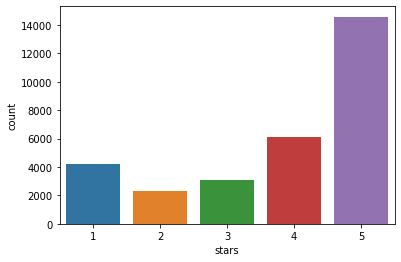

In [13]:
#print the counts of different values of 1, 2, 3, 4 and 5 star reviews
sns.countplot(x = reviews.stars)
plt.show()

In [14]:
def stars_to_y(stars):
    if stars >= 4:
        return 1
    elif stars == 3:
        return 0
    else:
        return -1

In [15]:
reviews['response'] = reviews.apply(lambda x: stars_to_y(x.stars), axis = 1)

In [16]:
reviews.head()

,stars,text,text1,response
0,5,Great food and great people. Authentic Vietnam...,great food great people authentic vietnamese f...,1
1,5,"Cute place, great for desert with friendly sta...",cute place great desert friendly staff in time...,1
2,4,I enjoy Sugar Bowl because of the three things...,enjoy sugar bowl three thing old town nostalgi...,1
3,5,Delicious. I love the classic look on the insi...,delicious love classic look inside chocolate b...,1
4,2,I bit overrated - you come here for the nostal...,bit overrated come nostalgia diner look ice cr...,-1


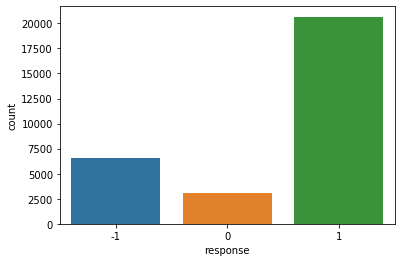

In [17]:
#print the counts of different values of 0 and 1 in y
sns.countplot(x = reviews.response)
plt.show()

In [18]:
#apply word tokenizer on the text 1 column to create a list of word tokens
reviews['tokenized'] = reviews['text1'].apply(word_tokenize)

In [19]:
reviews.head()

,stars,text,text1,response,tokenized
0,5,Great food and great people. Authentic Vietnam...,great food great people authentic vietnamese f...,1,"[great, food, great, people, authentic, vietna..."
1,5,"Cute place, great for desert with friendly sta...",cute place great desert friendly staff in time...,1,"[cute, place, great, desert, friendly, staff, ..."
2,4,I enjoy Sugar Bowl because of the three things...,enjoy sugar bowl three thing old town nostalgi...,1,"[enjoy, sugar, bowl, three, thing, old, town, ..."
3,5,Delicious. I love the classic look on the insi...,delicious love classic look inside chocolate b...,1,"[delicious, love, classic, look, inside, choco..."
4,2,I bit overrated - you come here for the nostal...,bit overrated come nostalgia diner look ice cr...,-1,"[bit, overrated, come, nostalgia, diner, look,..."


### Applying Count Vectorizer

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(lowercase = False, stop_words = 'english', min_df=2)

In [45]:
#Create the matrix of count vectorizer
X_count_vect = count_vect.fit_transform(reviews.text1)

In [46]:
#Shape of the matrix
X_count_vect.shape

(30282, 16717)

In [48]:
#Display the names of columns
X_names = count_vect.get_feature_names()
X_names[0:100]

['00',
 '000',
 '00am',
 '00pm',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '06pm',
 '07',
 '08',
 '09',
 '10',
 '100',
 '1000',
 '100000',
 '100g',
 '100th',
 '100x',
 '101',
 '1030',
 '105',
 '108',
 '10am',
 '10beef',
 '10danny',
 '10ish',
 '10min',
 '10mins',
 '10minutes',
 '10oz',
 '10p',
 '10pm',
 '10sushi',
 '10th',
 '10x',
 '11',
 '110',
 '111',
 '112',
 '1130',
 '11am',
 '11ish',
 '11pm',
 '11th',
 '12',
 '120',
 '1200',
 '123',
 '1230',
 '125',
 '12in',
 '12oz',
 '12pm',
 '12st',
 '12th',
 '13',
 '130',
 '135',
 '13th',
 '14',
 '140',
 '145',
 '14oz',
 '14th',
 '15',
 '150',
 '1500',
 '155',
 '15am',
 '15hr',
 '15min',
 '15mins',
 '15pm',
 '15th',
 '16',
 '160',
 '167',
 '16oz',
 '16st',
 '16th',
 '17',
 '170',
 '175',
 '17month',
 '17pm',
 '17th',
 '18',
 '180',
 '1800',
 '1894',
 '18oz',
 '18th',
 '19',
 '192',
 '1920',
 '1920s',
 '1921']

In [49]:
#Create a dataframe from the vectorizer matrix as that is a sparse matrix
X_count_vect = pd.DataFrame(X_count_vect.toarray(), columns=X_names)
X_count_vect.shape

(30282, 16717)

In [50]:
X_count_vect.head()

,00,000,00am,00pm,01,02,03,04,05,06,...,zoomed,zorro,zso,zucca,zucchini,zuki,zupas,zuzu,zzeeks,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split the Test and Training data

In [75]:
from sklearn.model_selection import train_test_split as cv
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [54]:
#Create the y variable from response variable
y = reviews.response

In [81]:
#Split the train and test
X_train_cv, X_test_cv, y_train_cv, y_test_cv = cv(X_count_vect, y, test_size=0.20, random_state = 5)

In [82]:
#print the shapes of train and test data sets
print('X_Train shape: ', X_train_cv.shape)
print('X_Test shape: ', X_test_cv.shape)

X_Train shape:  (24225, 16717)
X_Test shape:  (6057, 16717)


### Apply Random Forest

In [83]:
# Instantiate a random forests regressor 'rf' 300 estimators
rf = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)

# Fit 'rf' to the training set
rf_model = rf.fit(X_train_cv, y_train_cv)

In [84]:
# Predict the test set labels 'y_pred'
y_pred_rf = rf_model.predict(X_test_cv)
print(y_pred_rf[0:5])

#y_pred_rf

print(metrics.accuracy_score(y_test_cv, y_pred_rf))

[1 1 1 1 1]
0.6889549281822684


In [87]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cv, y_pred_rf))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1282
           0       0.00      0.00      0.00       602
           1       0.69      1.00      0.82      4173

    accuracy                           0.69      6057
   macro avg       0.23      0.33      0.27      6057
weighted avg       0.47      0.69      0.56      6057



### Apply Smote

In [59]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto')

X_train_sm, y_train_sm = sm.fit_sample(X_train_cv, y_train_cv)

In [60]:
X_train_sm.shape

(49464, 16717)

In [65]:
print('neg reviews count: ', y_train_sm[y_train_sm == -1].shape)
print('neu reviews count: ', y_train_sm[y_train_sm == 0].shape)
print('pos reviews count: ', y_train_sm[y_train_sm == 1].shape)

neg reviews count:  (16488,)
neu reviews count:  (16488,)
pos reviews count:  (16488,)


In [73]:
#Run Random forest on Smote Data
# Instantiate a random forests regressor 'rf' 300 estimators
rf_sm = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)
# Fit 'rf' to the training set
rf_model_sm = rf_sm.fit(X_train_sm, y_train_sm)

In [74]:
# Predict the test set labels 'y_pred'
y_pred_rf_sm = rf_model_sm.predict(X_test_cv)
print(y_pred_rf_sm[0:5])

#y_pred_rf

print(metrics.accuracy_score(y_test_cv, y_pred_rf_sm))

[1 1 1 1 0]
0.49760607561499093


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test_cv, y_pred_rf_sm))

              precision    recall  f1-score   support

          -1       0.28      0.49      0.36      1282
           0       0.15      0.14      0.15       602
           1       0.71      0.55      0.62      4173

    accuracy                           0.50      6057
   macro avg       0.38      0.40      0.37      6057
weighted avg       0.56      0.50      0.52      6057



### Using Tf-IDF vectorizer

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(analyzer='word')


In [22]:
tfidf_wm = tfidfvectorizer.fit_transform(reviews.text1)

In [23]:
#Shape of the matrix
tfidf_wm.shape

(30282, 32698)

In [24]:
#Display the names of columns
X_names_tfidf = tfidfvectorizer.get_feature_names()
X_names_tfidf[0:10]

['00',
 '000',
 '002',
 '00am',
 '00halloumi',
 '00options',
 '00p',
 '00pm',
 '00soon',
 '00this']

In [25]:
tfidf_wm = pd.DataFrame(tfidf_wm.toarray(), columns=X_names_tfidf)
tfidf_wm.shape

(30282, 32698)

In [97]:
tfidf_wm.head()

,00,000,002,00am,00halloumi,00options,00p,00pm,00soon,00this,...,食物不新鲜,食物味道和质量也很让人惊喜,食物質素ok,鲍鱼捞饭,鸡肉也很soft和juicy,麻辣锅真的好吃,黑口黑面嘅服務員,黑金流沙包还行吧,點好食都係冇用,龙虾饺子味道尚可
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
y_tfidf = reviews.response

In [29]:
#Important step to reduce memory usage
tfidf_wm = tfidf_wm.astype(np.float32)

In [34]:
#split the train and test data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = cv(tfidf_wm, y_tfidf, test_size=0.20, random_state = 5)

In [ ]:
#print the shapes of train and test data sets
print('X_Train shape: ', X_train_tfidf.shape)
print('X_Test shape: ', X_test_tfidf.shape)

### Apply Random Forest on tfidf data

In [136]:
# Instantiate a random forests regressor 'rf' 300 estimators
rf_tfidf = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)

# Fit 'rf' to the training set
rf_model = rf_tfidf.fit(X_train_tfidf, y_train_tfidf)

In [137]:
# Predict the test set labels 'y_pred'
y_pred_rf_tfidf = rf_model.predict(X_test_tfidf)
#print(y_pred_rf[0:5])

#y_pred_rf

print(metrics.accuracy_score(y_test_tfidf, y_pred_rf_tfidf))

0.6889549281822684


In [138]:
#Print classification report
print(classification_report(y_test_tfidf, y_pred_rf_tfidf))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      1282
           0       0.00      0.00      0.00       602
           1       0.69      1.00      0.82      4173

    accuracy                           0.69      6057
   macro avg       0.23      0.33      0.27      6057
weighted avg       0.47      0.69      0.56      6057



### Apply Smote to tfidf data

In [110]:
tfidf_wm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30282 entries, 0 to 30281
Columns: 32698 entries, 00 to 龙虾饺子味道尚可
dtypes: float64(32698)
memory usage: 7.4 GB


In [35]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='auto')

X_train_tfidf_sm, y_train_tfidf_sm = sm.fit_sample(X_train_tfidf, y_train_tfidf)

In [36]:
X_train_tfidf_sm.shape

(49464, 32698)

In [37]:
print('neg reviews count: ', y_train_tfidf_sm[y_train_tfidf_sm == -1].shape)
print('neu reviews count: ', y_train_tfidf_sm[y_train_tfidf_sm == 0].shape)
print('pos reviews count: ', y_train_tfidf_sm[y_train_tfidf_sm == 1].shape)

neg reviews count:  (16488,)
neu reviews count:  (16488,)
pos reviews count:  (16488,)


In [38]:
#Run Random forest on Smote Data
# Instantiate a random forests regressor 'rf' 300 estimators
rf_tfidf_sm = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)
# Fit 'rf' to the training set
rf_model_tfidf_sm = rf_tfidf_sm.fit(X_train_tfidf_sm, y_train_tfidf_sm)

In [41]:
#delete the above cell and run this cell
# Predict the test set labels 'y_pred'
y_pred_rf_tfidf_sm = rf_tfidf_sm.predict(X_test_tfidf)
#print(y_pred_rf_sm[0:5])

#y_pred_rf

print(metrics.accuracy_score(y_test_tfidf, y_pred_rf_tfidf_sm))

0.6329866270430906


In [44]:
#Print classification report
print(classification_report(y_test_tfidf, y_pred_rf_tfidf_sm))

              precision    recall  f1-score   support

          -1       0.50      0.18      0.27      1282
           0       0.17      0.23      0.19       602
           1       0.73      0.83      0.78      4173

    accuracy                           0.63      6057
   macro avg       0.46      0.42      0.41      6057
weighted avg       0.63      0.63      0.61      6057



### Using Word2Vec

In [45]:
#Using Word2vec
w2v_model = Word2Vec(reviews.tokenized, min_count = 1, size = 300, workers = 3, window = 3, sg = 1)

In [46]:
# to test the model
w2v_model.wv.most_similar('food')

[('execution', 0.7113255262374878),
 ('descent', 0.7095369100570679),
 ('paced', 0.7049338817596436),
 ('tldr', 0.7043085098266602),
 ('resturant', 0.7034519910812378),
 ('reliable', 0.7029644250869751),
 ('subpar', 0.7021903991699219),
 ('continuously', 0.6986159086227417),
 ('remains', 0.6977115273475647),
 ('wholesome', 0.6969280242919922)]

In [48]:
model_vector = []
for row in range(len(reviews)):
    model_vector.append((np.mean([w2v_model[token] for token in reviews.tokenized[row]], axis=0)).tolist())

In [49]:
len(model_vector)

30282

In [50]:
model_vector[0]

[-0.08953055739402771,
 0.026504190638661385,
 -0.08792384713888168,
 0.06348038464784622,
 0.007464339025318623,
 -0.18404120206832886,
 0.018718574196100235,
 0.21698547899723053,
 0.1260707676410675,
 0.17686417698860168,
 0.23176515102386475,
 -0.2302379459142685,
 0.14439889788627625,
 -0.04502977430820465,
 -0.00045244768261909485,
 0.29360780119895935,
 -0.05058625712990761,
 -0.30011609196662903,
 0.09022786468267441,
 0.21595534682273865,
 -0.09986338764429092,
 -0.05837155878543854,
 -0.07555793225765228,
 -0.0021786484867334366,
 -0.08805146813392639,
 0.026707634329795837,
 -0.13171254098415375,
 0.2738863229751587,
 -0.3072023391723633,
 -0.06440430134534836,
 -0.1693975329399109,
 -0.0651603415608406,
 0.14394627511501312,
 0.08442238718271255,
 0.003916487097740173,
 0.20230713486671448,
 0.00549214705824852,
 -0.05643950775265694,
 -0.28805437684059143,
 0.010408480651676655,
 0.10511216521263123,
 0.017953166738152504,
 0.03333001956343651,
 0.09634464234113693,
 -0.11

In [51]:
# convert model_vec list of lists to an array to train and test the model
array_vec = np.array([np.array(xi) for xi in model_vector])

In [52]:
array_vec[0]

array([-0.08953056,  0.02650419, -0.08792385,  0.06348038,  0.00746434,
       -0.1840412 ,  0.01871857,  0.21698548,  0.12607077,  0.17686418,
        0.23176515, -0.23023795,  0.1443989 , -0.04502977, -0.00045245,
        0.2936078 , -0.05058626, -0.30011609,  0.09022786,  0.21595535,
       -0.09986339, -0.05837156, -0.07555793, -0.00217865, -0.08805147,
        0.02670763, -0.13171254,  0.27388632, -0.30720234, -0.0644043 ,
       -0.16939753, -0.06516034,  0.14394628,  0.08442239,  0.00391649,
        0.20230713,  0.00549215, -0.05643951, -0.28805438,  0.01040848,
        0.10511217,  0.01795317,  0.03333002,  0.09634464, -0.11438015,
       -0.28118175, -0.17955241,  0.05506412,  0.10435453, -0.09035213,
        0.07268032,  0.17128946, -0.01461453, -0.02385287, -0.26960331,
       -0.12613566,  0.04788706, -0.04010107, -0.1585539 ,  0.03995739,
        0.17123571, -0.04933512,  0.2476538 , -0.24211545,  0.13896658,
       -0.10798721,  0.12369256,  0.11825578,  0.06428251, -0.19

In [56]:
#Split train and test data
X_train_wv, X_test_wv, y_train_wv, y_test_wv = cv(array_vec, y, test_size=0.20, random_state = 5)

In [57]:
X_train_wv.shape, y_train_wv.shape

((24225, 300), (24225,))

In [58]:
# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)

# Fit 'rf' to the training set
rf_model = rf.fit(X_train_wv, y_train_wv)

In [59]:
# Predict the test set labels 'y_pred'
y_pred_rf_wv = rf.predict(X_test_wv)

print(metrics.accuracy_score(y_test_wv, y_pred_rf_wv))

0.7713389466732706


In [60]:
#Print classification report
print(classification_report(y_test_wv, y_pred_rf_wv))

              precision    recall  f1-score   support

          -1       0.88      0.41      0.56      1282
           0       0.00      0.00      0.00       602
           1       0.76      0.99      0.86      4173

    accuracy                           0.77      6057
   macro avg       0.55      0.47      0.47      6057
weighted avg       0.71      0.77      0.71      6057



### Word2Vec with Smote

In [61]:
sm = SMOTE(sampling_strategy='auto')

X_train_smwv, y_train_smwv = sm.fit_sample(X_train_wv, y_train_wv)

In [62]:
X_train_smwv.shape, y_train_smwv.shape

((49464, 300), (49464,))

In [63]:
# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)

# Fit 'rf' to the training set
rf_model = rf.fit(X_train_smwv, y_train_smwv)

In [64]:
# Predict the test set labels 'y_pred'
y_pred_rf_wv = rf.predict(X_test_wv)

print(metrics.accuracy_score(y_test_wv, y_pred_rf_wv))

0.7746409113422487


In [65]:
#Print classification report
print(classification_report(y_test_wv, y_pred_rf_wv))

              precision    recall  f1-score   support

          -1       0.70      0.74      0.72      1282
           0       0.28      0.42      0.33       602
           1       0.92      0.84      0.88      4173

    accuracy                           0.77      6057
   macro avg       0.63      0.67      0.64      6057
weighted avg       0.81      0.77      0.79      6057



### Top2Vec

In [20]:
review_list = [str(x) for x in reviews.text1]

In [77]:
review_list[0:3]

['great food great people authentic vietnamese food friendly neighbourhood restaurant nee anchor place know everyone welcoming',
 'cute place great desert friendly staff in time scottsdale visit place coffee cafe banana split great',
 'enjoy sugar bowl three thing old town nostalgia good food enjoy sugar bowl blatant decision owner management enhance game arcade area back never find day "arcade" game working last time wiped down? germ warfare ticket machine 1985? love go back spending money overlooking broke horse one week broke toy next imagine "private equity" guy got hold arcade room $$ boom $$']

In [21]:
t2v_model = Top2Vec(review_list)

2021-02-11 11:59:34,283 - top2vec - INFO - Pre-processing documents for training
2021-02-11 11:59:37,671 - top2vec - INFO - Creating joint document/word embedding
2021-02-11 12:01:13,575 - top2vec - INFO - Creating lower dimension embedding of documents
2021-02-11 12:01:41,483 - top2vec - INFO - Finding dense areas of documents
2021-02-11 12:01:43,837 - top2vec - INFO - Finding topics


#### Analyze topics

In [22]:
t2v_model.get_num_topics()

389

In [24]:
topic_sizes, topic_nums = t2v_model.get_topic_sizes()
topic_sizes

array([1113,  675,  490,  377,  331,  330,  329,  296,  289,  281,  257,
        225,  224,  215,  215,  207,  205,  204,  194,  179,  179,  178,
        177,  177,  175,  175,  171,  169,  156,  154,  150,  150,  146,
        144,  143,  140,  139,  138,  136,  130,  130,  129,  128,  127,
        126,  124,  121,  117,  117,  116,  116,  114,  113,  113,  109,
        107,  105,  104,  104,  104,  102,  102,  100,   97,   97,   95,
         94,   94,   94,   93,   91,   91,   91,   90,   89,   88,   88,
         87,   86,   86,   86,   85,   85,   84,   84,   83,   83,   83,
         83,   82,   81,   81,   80,   80,   80,   79,   78,   78,   77,
         77,   77,   75,   75,   75,   74,   74,   74,   73,   73,   73,
         73,   73,   72,   72,   72,   71,   71,   71,   70,   70,   70,
         70,   70,   69,   69,   69,   69,   68,   68,   68,   68,   68,
         68,   68,   67,   66,   66,   66,   65,   65,   65,   65,   65,
         64,   64,   63,   63,   63,   62,   62,   

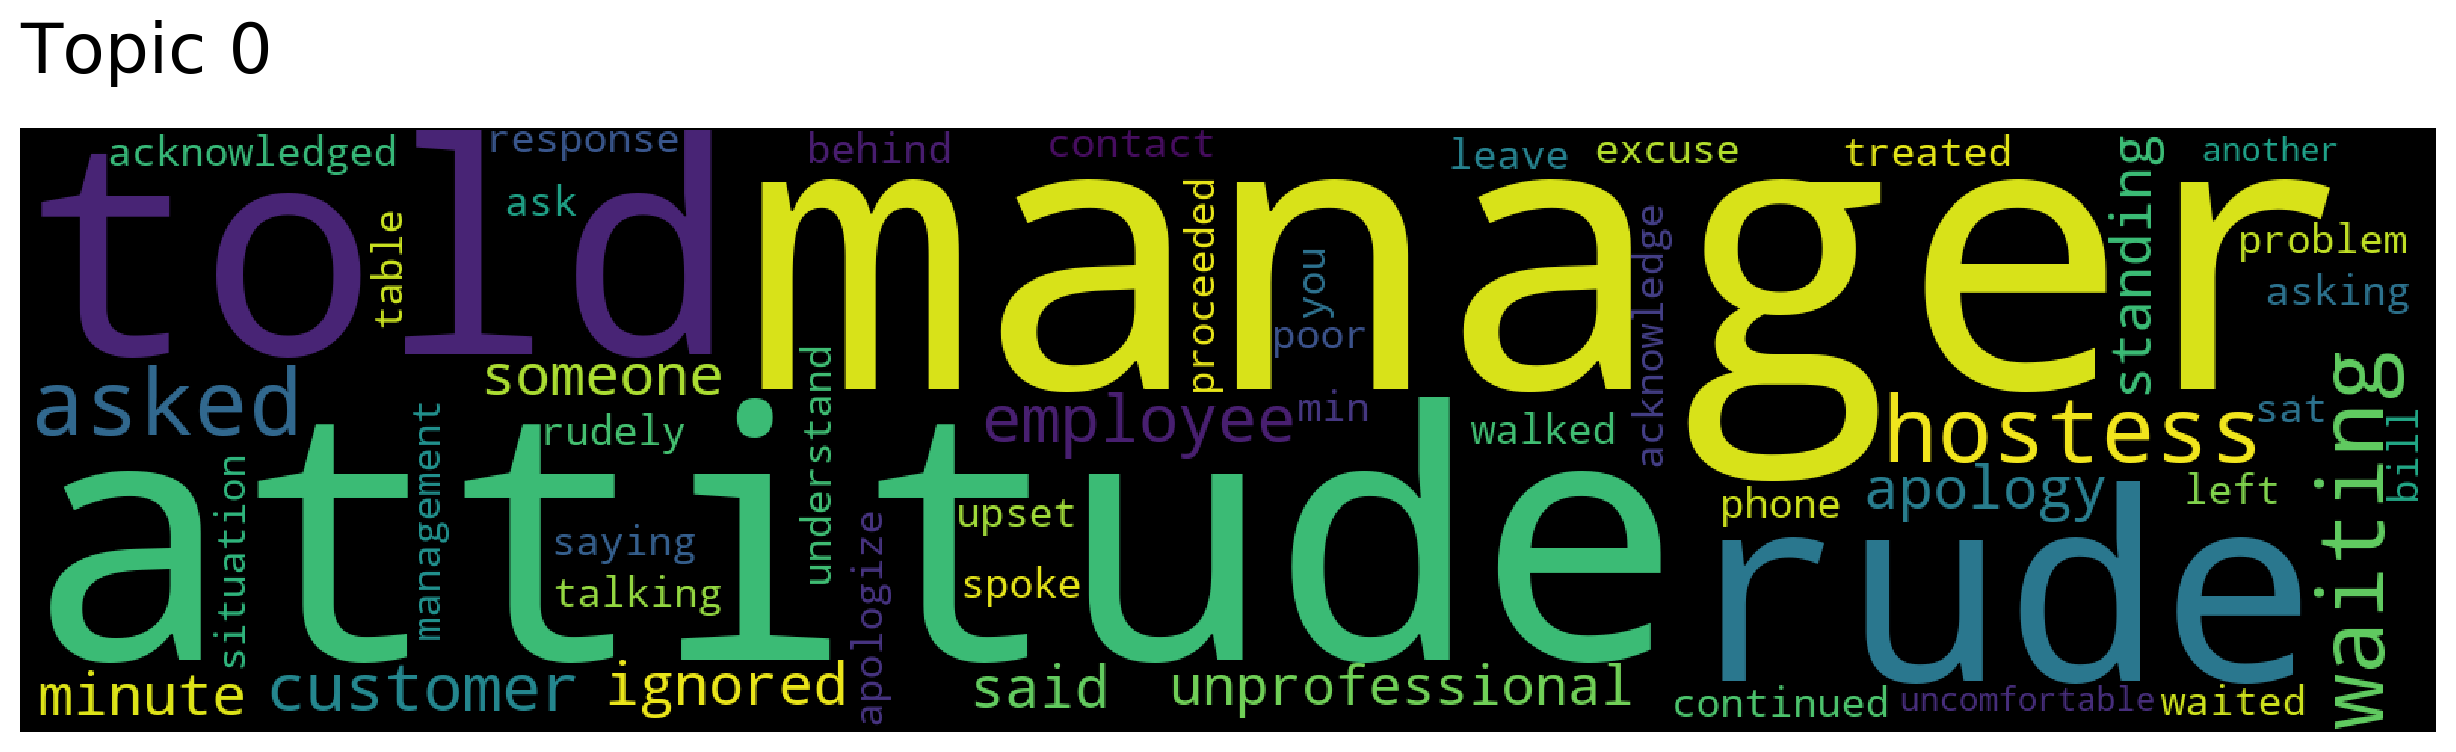

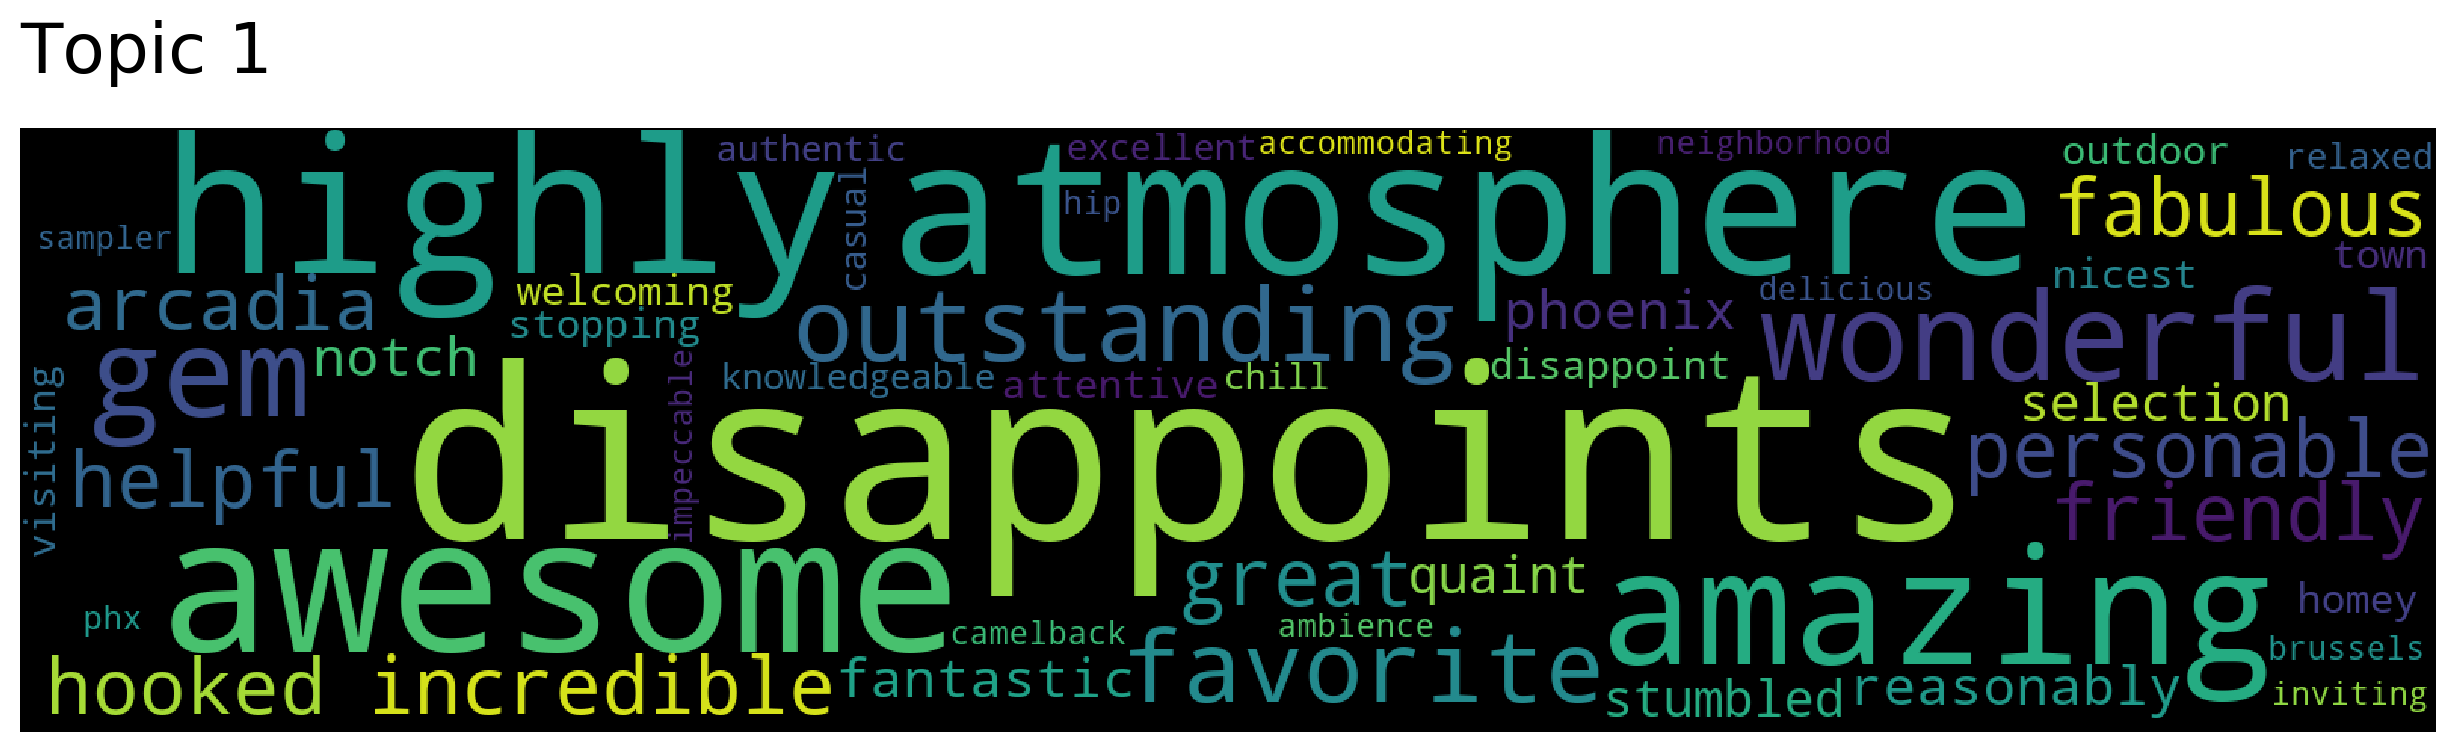

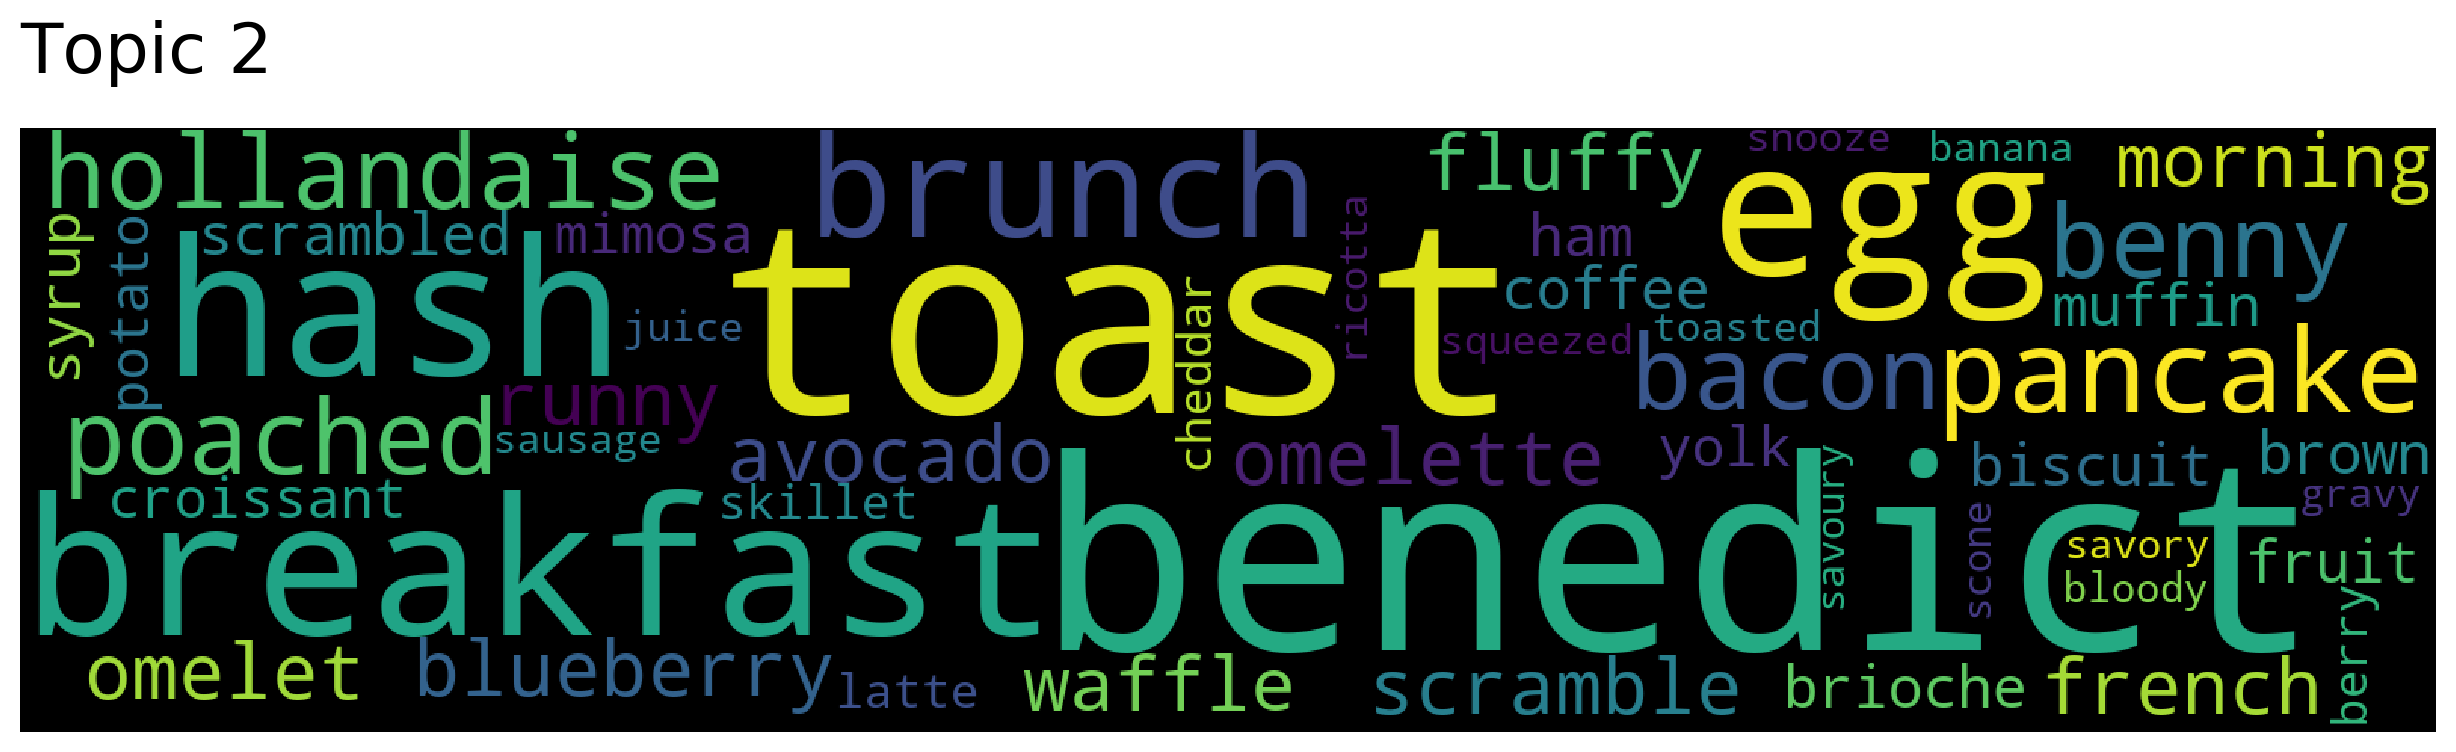

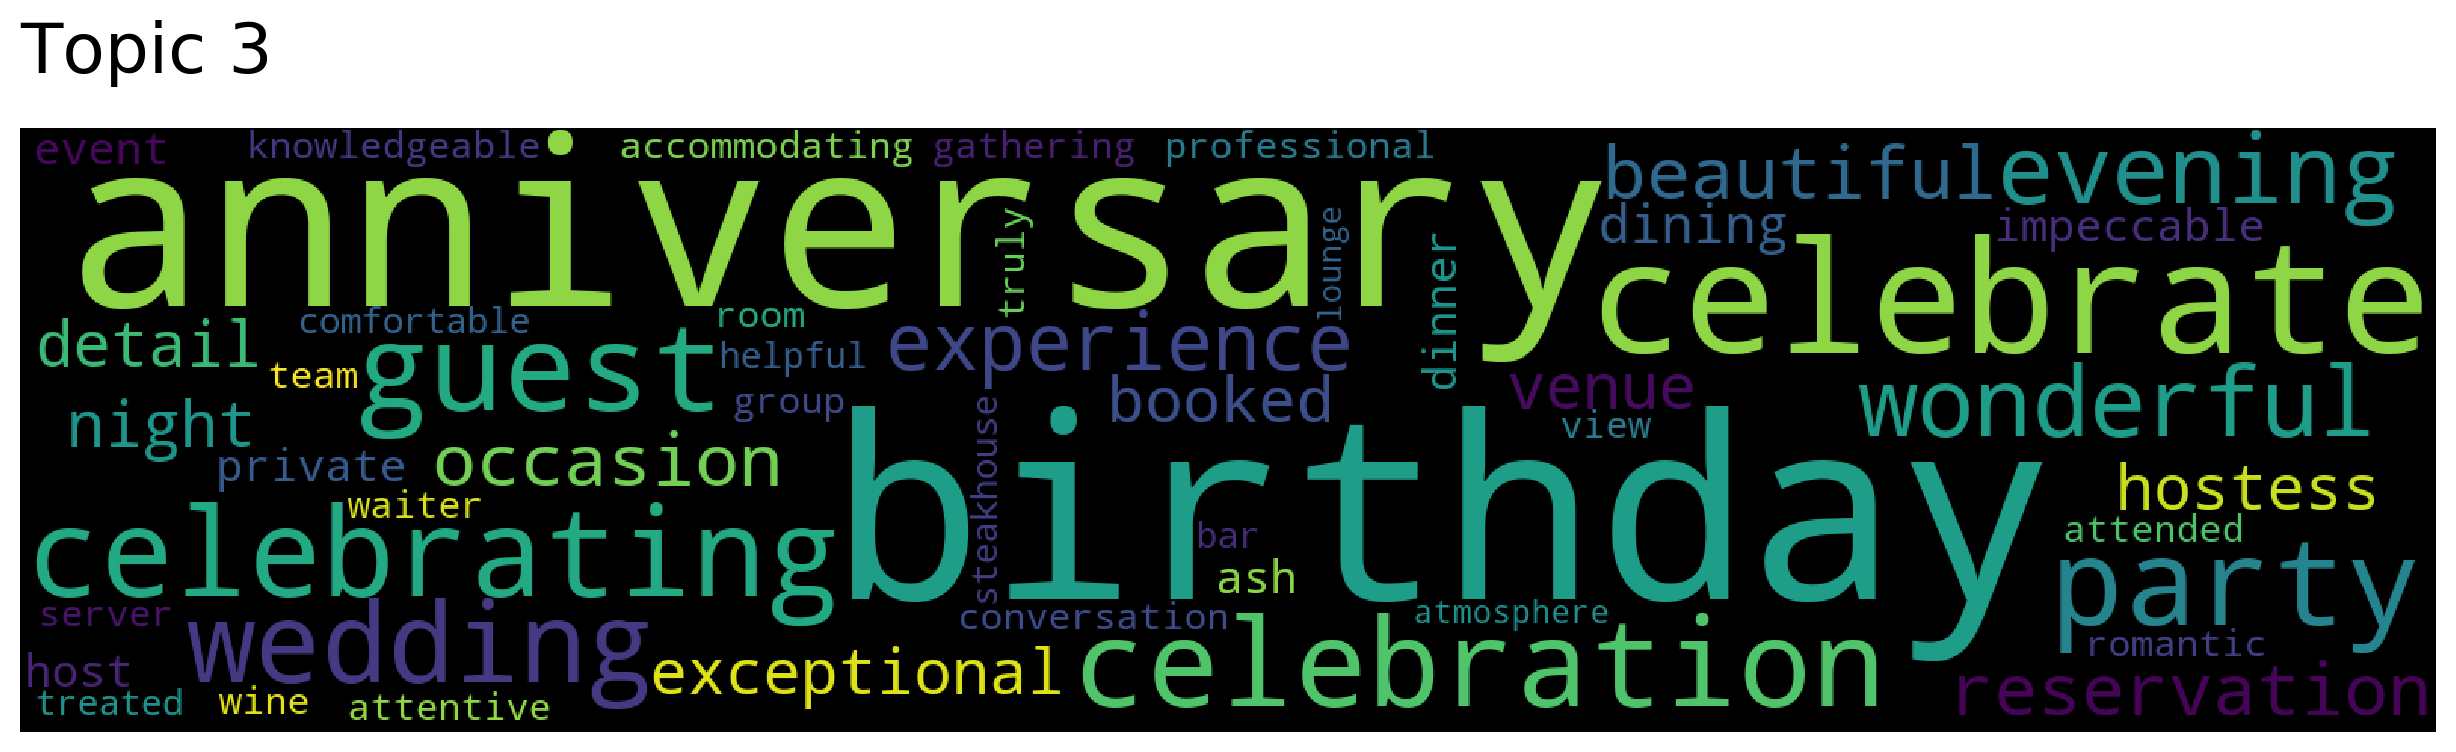

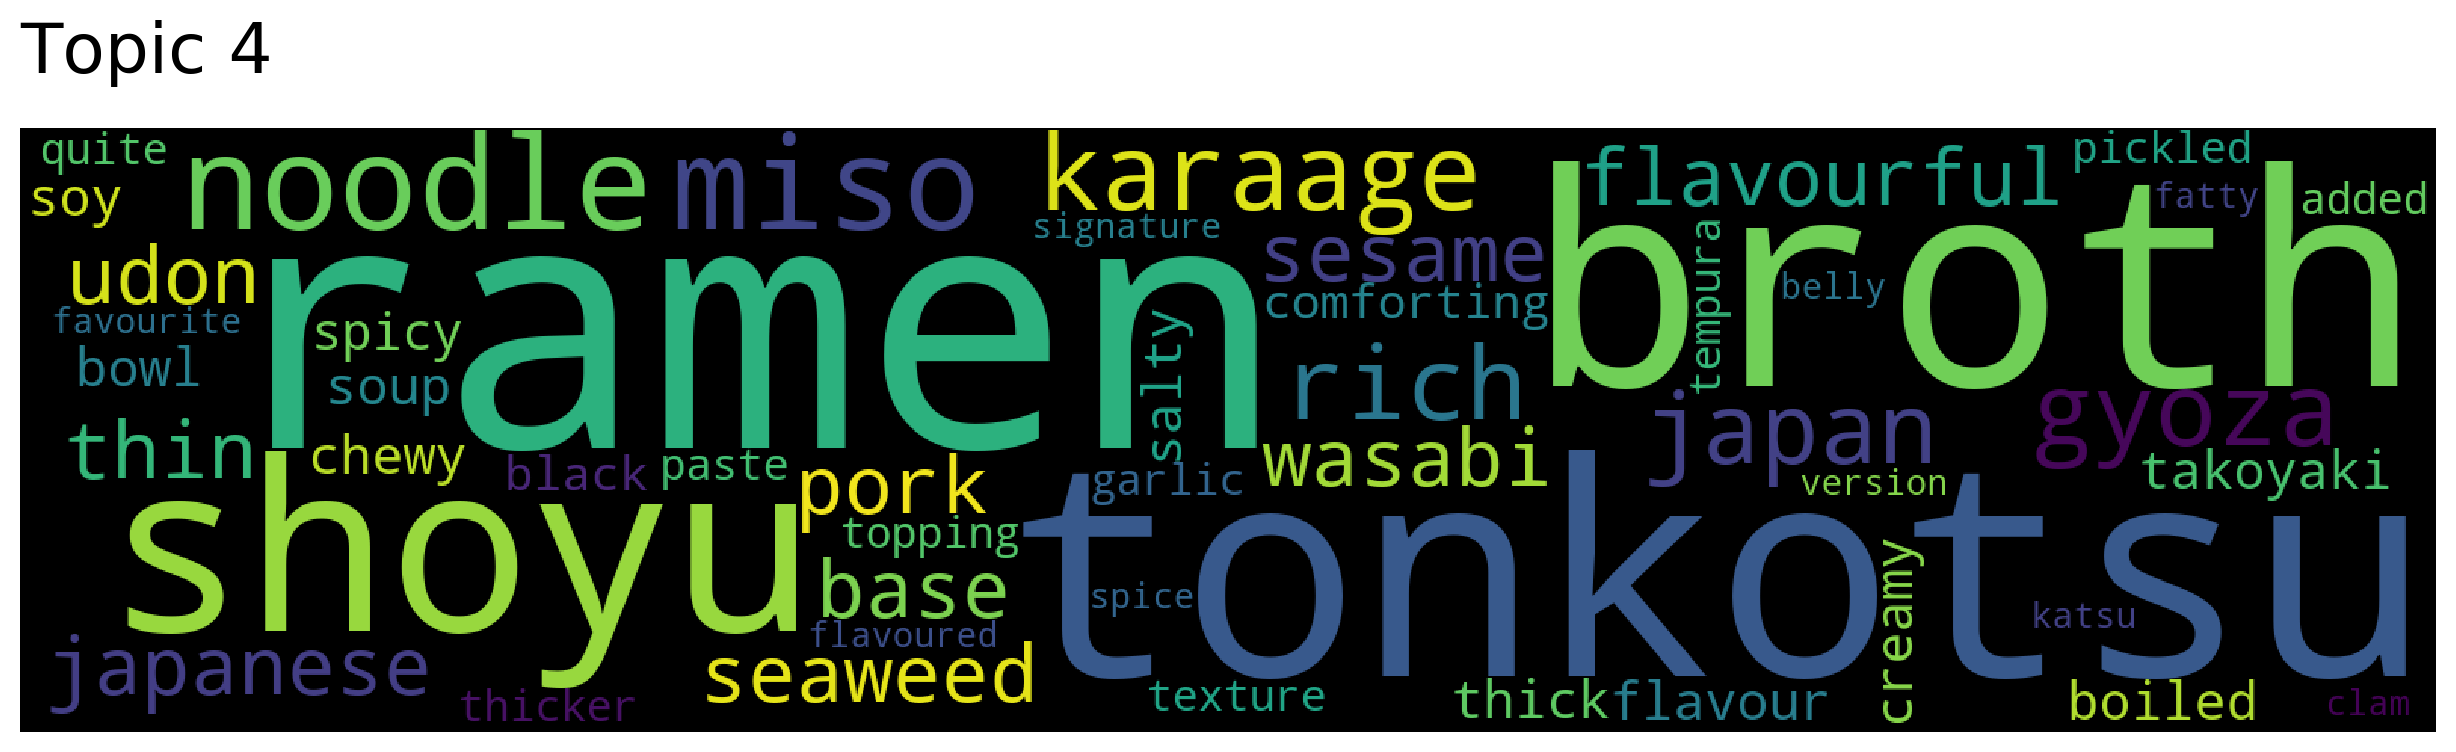

In [25]:
for topic in topic_nums[0:5]:
    t2v_model.generate_topic_wordcloud(topic, background_color="black")

In [54]:
topic_words, word_scores, topic_nums = t2v_model.get_topics()

In [56]:
len(word_scores)

389

In [27]:
topic_words[0]

array(['manager', 'attitude', 'told', 'rude', 'hostess', 'asked',
       'waiting', 'employee', 'customer', 'ignored', 'minute', 'someone',
       'apology', 'said', 'unprofessional', 'standing', 'acknowledged',
       'acknowledge', 'saying', 'left', 'you', 'continued', 'contact',
       'understand', 'asking', 'management', 'response', 'proceeded',
       'leave', 'table', 'treated', 'rudely', 'walked', 'talking',
       'apologize', 'waited', 'phone', 'min', 'poor', 'situation',
       'spoke', 'problem', 'upset', 'behind', 'ask', 'bill', 'excuse',
       'sat', 'uncomfortable', 'another'], dtype='<U14')

In [33]:
word_scores[0]

array([0.596444  , 0.55295765, 0.5475152 , 0.5459171 , 0.5277246 ,
       0.52512074, 0.51117766, 0.5064298 , 0.48446533, 0.4820181 ,
       0.47720948, 0.47149223, 0.47131044, 0.46542227, 0.45895296,
       0.4457343 , 0.43975002, 0.43753636, 0.43600005, 0.4346196 ,
       0.43383992, 0.4321218 , 0.4316602 , 0.42874697, 0.42695844,
       0.42459044, 0.42381033, 0.4231978 , 0.4220298 , 0.42127475,
       0.42023236, 0.4178588 , 0.41583416, 0.4139378 , 0.41382954,
       0.409803  , 0.40742648, 0.4056316 , 0.40513322, 0.40208137,
       0.40172467, 0.39974105, 0.39850754, 0.39815846, 0.39815187,
       0.39809614, 0.39517215, 0.39306983, 0.39269266, 0.39142627],
      dtype=float32)

In [49]:
def topic_calc(review,topic_words,word_score):
    score = 0.0
    for word,scr in zip(topic_words,word_score):
        if word in review.split():
            score += scr
            
    return score

In [50]:
sco = topic_calc1(reviews.text1[0], topic_words[1],word_scores[1])
sco

great
0.04869325
friendly
0.04669306
welcoming
0.03243377
authentic
0.021542821


0.14936290308833122

In [59]:
col_name = ['Topic_' + str(i) for i in range(len(word_scores))]
col_name

['Topic_0',
 'Topic_1',
 'Topic_2',
 'Topic_3',
 'Topic_4',
 'Topic_5',
 'Topic_6',
 'Topic_7',
 'Topic_8',
 'Topic_9',
 'Topic_10',
 'Topic_11',
 'Topic_12',
 'Topic_13',
 'Topic_14',
 'Topic_15',
 'Topic_16',
 'Topic_17',
 'Topic_18',
 'Topic_19',
 'Topic_20',
 'Topic_21',
 'Topic_22',
 'Topic_23',
 'Topic_24',
 'Topic_25',
 'Topic_26',
 'Topic_27',
 'Topic_28',
 'Topic_29',
 'Topic_30',
 'Topic_31',
 'Topic_32',
 'Topic_33',
 'Topic_34',
 'Topic_35',
 'Topic_36',
 'Topic_37',
 'Topic_38',
 'Topic_39',
 'Topic_40',
 'Topic_41',
 'Topic_42',
 'Topic_43',
 'Topic_44',
 'Topic_45',
 'Topic_46',
 'Topic_47',
 'Topic_48',
 'Topic_49',
 'Topic_50',
 'Topic_51',
 'Topic_52',
 'Topic_53',
 'Topic_54',
 'Topic_55',
 'Topic_56',
 'Topic_57',
 'Topic_58',
 'Topic_59',
 'Topic_60',
 'Topic_61',
 'Topic_62',
 'Topic_63',
 'Topic_64',
 'Topic_65',
 'Topic_66',
 'Topic_67',
 'Topic_68',
 'Topic_69',
 'Topic_70',
 'Topic_71',
 'Topic_72',
 'Topic_73',
 'Topic_74',
 'Topic_75',
 'Topic_76',
 'Topic_7

In [63]:
for i in range(len(word_scores)):
    reviews[col_name[i]] = reviews.apply(lambda x: topic_calc(x.text1,topic_words[i],word_scores[i]),axis=1)
        
        
#reviews['response'] = reviews.apply(lambda x: stars_to_y(x.stars), axis = 1)

In [64]:
reviews.head()

,stars,text,text1,response,tokenized,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,...,Topic_379,Topic_380,Topic_381,Topic_382,Topic_383,Topic_384,Topic_385,Topic_386,Topic_387,Topic_388
0,5,Great food and great people. Authentic Vietnam...,great food great people authentic vietnamese f...,1,"[great, food, great, people, authentic, vietna...",0.00000,0.149363,0.000000,0.00000,0.000000,...,0.210593,0.000000,0.000000,0.000000,0.229521,0.0,0.000000,0.000000,0.000000,0.249125
1,5,"Cute place, great for desert with friendly sta...",cute place great desert friendly staff in time...,1,"[cute, place, great, desert, friendly, staff, ...",0.00000,0.095386,0.635464,0.00000,0.000000,...,0.500979,0.000000,0.000000,0.000000,0.000000,0.0,0.208114,0.000000,0.221608,0.000000
2,4,I enjoy Sugar Bowl because of the three things...,enjoy sugar bowl three thing old town nostalgi...,1,"[enjoy, sugar, bowl, three, thing, old, town, ...",0.42459,0.022943,0.000000,0.34849,0.348862,...,0.638043,0.406603,0.225750,0.205147,0.000000,0.0,0.000000,0.472408,0.000000,0.000000
3,5,Delicious. I love the classic look on the insi...,delicious love classic look inside chocolate b...,1,"[delicious, love, classic, look, inside, choco...",0.00000,0.010203,0.000000,0.00000,0.000000,...,0.205137,0.000000,0.236415,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,2,I bit overrated - you come here for the nostal...,bit overrated come nostalgia diner look ice cr...,-1,"[bit, overrated, come, nostalgia, diner, look,...",0.50643,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,1.231358,0.202569,0.000000,0.0,0.263511,0.000000,0.000000,0.000000


In [65]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30282 entries, 0 to 30281
Columns: 394 entries, stars to Topic_388
dtypes: float64(389), int64(2), object(3)
memory usage: 91.0+ MB


In [66]:
y_t2v = reviews.response

In [67]:
X_t2v = reviews.drop(['stars', 'text','text1','response','tokenized'],axis=1)

In [68]:
X_t2v.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,...,Topic_379,Topic_380,Topic_381,Topic_382,Topic_383,Topic_384,Topic_385,Topic_386,Topic_387,Topic_388
0,0.00000,0.149363,0.000000,0.00000,0.000000,0.0,0.000000,0.242445,0.704734,0.0,...,0.210593,0.000000,0.000000,0.000000,0.229521,0.0,0.000000,0.000000,0.000000,0.249125
1,0.00000,0.095386,0.635464,0.00000,0.000000,0.0,0.000000,0.000000,0.359195,0.0,...,0.500979,0.000000,0.000000,0.000000,0.000000,0.0,0.208114,0.000000,0.221608,0.000000
2,0.42459,0.022943,0.000000,0.34849,0.348862,0.0,0.664629,0.000000,0.000000,0.0,...,0.638043,0.406603,0.225750,0.205147,0.000000,0.0,0.000000,0.472408,0.000000,0.000000
3,0.00000,0.010203,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.327350,0.0,...,0.205137,0.000000,0.236415,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.50643,0.000000,0.000000,0.00000,0.000000,0.0,0.604754,0.000000,0.000000,0.0,...,0.000000,0.000000,1.231358,0.202569,0.000000,0.0,0.263511,0.000000,0.000000,0.000000


### Split the train and test data

In [69]:
#Split train and test data
X_train_t2v, X_test_t2v, y_train_t2v, y_test_t2v = cv(X_t2v, y_t2v, test_size=0.20, random_state = 5)

In [70]:
# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)

# Fit 'rf' to the training set
rf_model = rf.fit(X_train_t2v, y_train_t2v)

In [71]:
# Predict the test set labels 'y_pred'
y_pred_rf_t2v = rf.predict(X_test_t2v)

print(metrics.accuracy_score(y_test_t2v, y_pred_rf_t2v))

0.7693577678718838


In [72]:
#Print classification report
print(classification_report(y_test_t2v, y_pred_rf_t2v))

              precision    recall  f1-score   support

          -1       0.85      0.42      0.56      1282
           0       0.00      0.00      0.00       602
           1       0.76      0.99      0.86      4173

    accuracy                           0.77      6057
   macro avg       0.54      0.47      0.47      6057
weighted avg       0.70      0.77      0.71      6057



#### Smote on Top2vec

In [73]:
sm = SMOTE(sampling_strategy='auto')

X_train_smwv, y_train_smwv = sm.fit_sample(X_train_t2v, y_train_t2v)

In [74]:
# Instantiate a random forests regressor 'rf' 400 estimators
rf = RandomForestClassifier(n_estimators=400,
                            min_samples_leaf=0.1,
                            random_state=1)

# Fit 'rf' to the training set
rf_model = rf.fit(X_train_smwv, y_train_smwv)

In [75]:
# Predict the test set labels 'y_pred'
y_pred_rf_t2v = rf.predict(X_test_t2v)

print(metrics.accuracy_score(y_test_t2v, y_pred_rf_t2v))

0.7830609212481426


In [76]:
#Print classification report
print(classification_report(y_test_t2v, y_pred_rf_t2v))

              precision    recall  f1-score   support

          -1       0.75      0.72      0.74      1282
           0       0.27      0.39      0.32       602
           1       0.90      0.86      0.88      4173

    accuracy                           0.78      6057
   macro avg       0.64      0.66      0.65      6057
weighted avg       0.81      0.78      0.79      6057

